In [1]:
from functools import reduce
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from numpy import sin as S
from numpy import cos as C
import math
from math import atan2, sqrt
from math import pi
from matrices import *

In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In c:\users\iguru\documents\venv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.


# Params

In [2]:
l1 = 1
l2 = 1
l3 = 1

# 1. Calculate Jacobian (skew theory or numeric method)

In [3]:
def J_skew(Q):
    [q1,q2,d3] = Q
    trans = [Rz(q1), Tz(l1), 'O', Ry(q2), Tz(l2), 'O', Ry(d3), Tz(l3), 'O']
    
    res = trans[0]
    Ts = [np.eye(4,4)]
    for t in trans[1:]:
        if t == 'O':
            Ts.append(res)
            continue
        res = res @ t
    
    T00 = Ts[0]
    T01 = Ts[1]
    T02 = Ts[2]
    T03 = Ts[3]
    
    Z0 = T00[:3,2] # Rz
    Z1 = T01[:3,1] # Ry
    Z2 = T02[:3,0] # Tx
    
    O3 = T03[:3,3]
    O2 = T02[:3,3]
    O1 = T01[:3,3]
    O0 = T00[:3,3]
    
    J1 = np.concatenate([np.cross(Z0, (O3 - O0)), Z0]).reshape(-1,1)
    J2 = np.concatenate([np.cross(Z1, (O3 - O1)), Z1]).reshape(-1,1)
    J3 = np.concatenate([Z2, [0,0,0]]).reshape(-1,1)
    
    return np.concatenate([J1,J2,J3], axis=1)

J_skew([pi/2, pi/2, pi/2])

c:\users\iguru\documents\venv\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


array([[-1., -0.,  0.],
       [ 0., -1.,  0.],
       [ 0., -1., -1.],
       [ 0., -1.,  0.],
       [ 0.,  0.,  0.],
       [ 1.,  0.,  0.]])

# 2. Joint trajectory q(t) from q(0) = (0, 0, 0) to q(2) = (2, 3, 4) with null initial and final velocities and accelerations. (polynomial)


In [4]:
# params

Q0 = [0,0,0]
dQ0 = [0,0,0]
ddQ0 = [0,0,0]

Q2 = [2,3,4]
dQ2 = [0,0,0]
ddQ2 = [0,0,0]

f = 2

In [5]:
def solve_trajectory(q0_params, qf_params, f):
    """
    :param q0_params: array of q0 constraints
    :param qf_params: array of qf constraints
    :param f: time of movement finishing
    """
    q0_params = np.array(q0_params).flatten().reshape(-1,1)
    qf_params = np.array(qf_params).flatten().reshape(-1,1)
    
    assert len(q0_params) == len(qf_params) # change if new conditions
    if len(q0_params) == len(qf_params) == 3:
        A = np.array([
            [1,0,0,0,0,0],
            [0,1,0,0,0,0],
            [0,0,1,0,0,0],
            [1, f,   f**2,    f**3,    f**4,    f**5],
            [0, 1,   2*f,     3*f**2,  4*f**3,  5*f**4],
            [0, 0,   1,       6*f,     12*f**2, 20*f**3],
        ])
                
        return np.linalg.inv(A) @ np.concatenate([q0_params, qf_params])

In [6]:
coefs = []
for q0,dq0,ddq0,qf,dqf,ddqf in zip(Q0, dQ0, ddQ0, Q2,dQ2,ddQ2):
    cs = solve_trajectory([q0,dq0,ddq0], [qf,dqf,ddqf], f)
    coefs.append(cs)

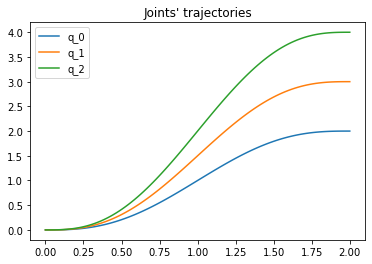

In [7]:
Xs = np.linspace(0,f,100)

def poly(cs, x):
    return(sum([ a*x**p for p,a in enumerate(cs)]))


for i, cs in enumerate(coefs):
    Ys = [poly(cs, x) for x in Xs]
    plt.plot(Xs,Ys, label='q_' + str(i))
    
plt.legend()
plt.title("Joints' trajectories")
plt.show()

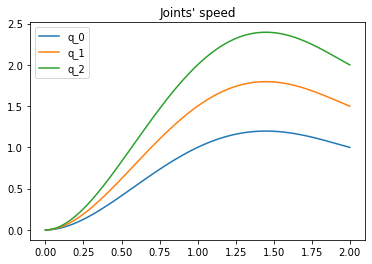

In [8]:
Xs = np.linspace(0,f,100)

for i, cs in enumerate(coefs):
    Ys = [poly(cs[1:], x) for x in Xs]
    plt.plot(Xs,Ys, label='q_' + str(i))
    
plt.legend()
plt.title("Joints' speed")
plt.show()

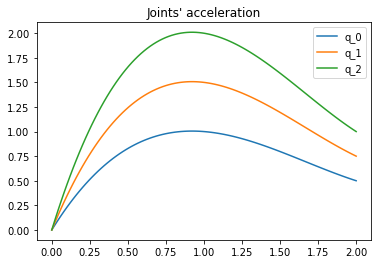

In [9]:
Xs = np.linspace(0,f,100)


for i, cs in enumerate(coefs):
    Ys = [poly(cs[2:], x) for x in Xs]
    plt.plot(Xs,Ys, label='q_' + str(i))
    
plt.legend()
plt.title("Joints' acceleration")
plt.show()

# 3. Joint trajectory for the following commands: 

#### PTP – q1 = (0, 0, 0) to q2 = (2, 3, 4) (trapezoidal)

o Controller command interpretation frequency – f = 100 Hz

o Maximum joint velocity – 1 rad/s

o Maximum joint acceleration – 10 rad/s2

I used **Slew** motion type - the laziest one

In [10]:
from collections import namedtuple

Motion = namedtuple('Motion', ['t1', 'tau', 'dq_max', 'ddq', 'orientation', 'q0'])

In [11]:
def q(t, motion):
    t = min(t, motion.t1 + motion.tau)
    
    if t <= motion.t1:
        res = t**2 * motion.ddq / 2
    elif t <= motion.tau:
        res = (2*t - motion.t1) / 2 * motion.dq_max
    else:
        res = (2*motion.tau - motion.t1) / 2 * motion.dq_max \
                + (motion.t1**2 * motion.ddq / 2 \
                   - (motion.t1 + motion.tau - t)**2* motion.ddq / 2) # difference of triangles
    return motion.q0 + motion.orientation * res

In [12]:
# params
hz = 100
per = 1.0 / hz
Q1 = [0,0,0]
Q2 = [2,3,4]

dq_max = 1.0
ddq_max = 10.0

def sync(x, per):
    return math.ceil(x / per) * per

motion_params = []

Motion = namedtuple('Motion', ['t1', 'tau', 'dq_max', 'ddq', 'orientation', 'q0'])
motion_params = []

X = np.linspace(0,5,100)

ddQs = []
dQs = []
Qs = []

for q1, q2 in zip(Q1,Q2):
    dq = abs(q2 - q1)
    orientation = math.copysign(1, q2 - q1)
    t1 = sync(dq_max / ddq_max, per)
    tau = sync(dq / dq_max,per)
    
    # Fixing dq and ddq after sync
    ddq = dq / t1 / tau
    dq = dq / tau
    assert ddq <= ddq_max
    assert dq <= dq_max
    
    
    motion = Motion(t1, tau, dq,ddq, orientation, q1)
    
    # Triangle case with sync handling
    if sqrt(dq*ddq) <= dq:
        print("Panic (triangle)")
        
        t1 = sync(sqrt(dq/ddq_max), per)
        tau = t1
        dq_max_dash = dq / t1
        ddq = dq_max_dash / t1
        motion = Motion(t1,tau, dq_max_dash,ddq, orientation, q1)
    
    Q = []
    dQ = []
    ddQ = []
    for x in X:
        t = min(x, motion.t1 + motion.tau)
        if t < motion.t1:
            res = t**2 * motion.ddq / 2
            vel = motion.ddq * t
            acc = motion.ddq
        elif t < motion.tau:
            res = (2*t - motion.t1) / 2 * motion.dq_max
            vel = motion.dq_max
            acc = 0
        else:
            res = (2*motion.tau - motion.t1) / 2 * motion.dq_max \
                    + (motion.t1**2 * motion.ddq / 2 \
                       - (motion.t1 + motion.tau - t)**2* motion.ddq / 2) # difference of triangles
            vel = motion.dq_max - motion.ddq * (t - motion.tau)
            acc = -motion.ddq
        if x > t:
            acc = 0
        Q.append(motion.q0 + motion.orientation * res)
        dQ.append(vel * motion.orientation)
        ddQ.append(motion.orientation*acc)

    Qs.append(Q)
    dQs.append(dQ)
    ddQs.append(ddQ)

    motion_params.append(motion)

2.0
3.0
4.0


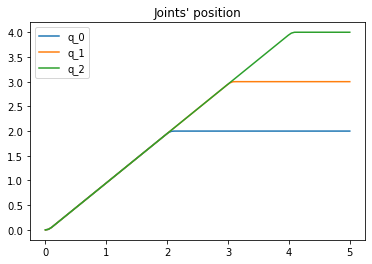

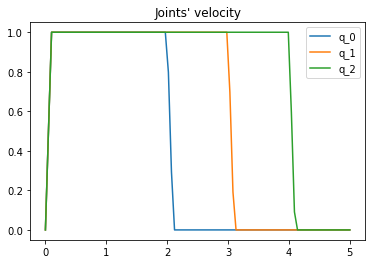

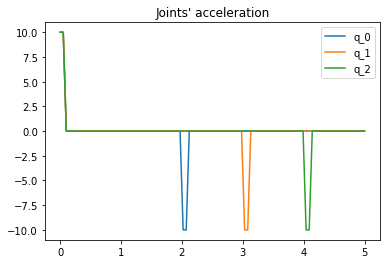

In [13]:
for i in range(len(Qs)):
    plt.plot(X, Qs[i], label="q_" + str(i))
    plt.legend()
    plt.title("Joints' position")
    print(Qs[i][-1])
plt.show()

for i in range(len(dQs)):
    plt.plot(X, dQs[i], label="q_" + str(i))
    plt.legend()
    plt.title("Joints' velocity")
plt.show()

for i in range(len(ddQs)):
    plt.plot(X, ddQs[i], label="q_" + str(i))
    plt.legend()
    plt.title("Joints' acceleration")
plt.show()

# 4. Joint trajectory for the following commands: 
LIN – p1 = (1, 0, 1) to p2 = (√2/2, √2/2, 1.2) (trapezoidal)

o Controller command interpretation frequency – f = 100 Hz

o Maximum linear velocity – 1 m/s

o Maximum linear acceleration – 10 m/s2


In [14]:
# params

p1 = [1,0,1]
p2 = [sqrt(2)/2, sqrt(2)/2, 1.2]

hz = 100
lvm = 1
lam = 10

p1,p2

([1, 0, 1], [0.7071067811865476, 0.7071067811865476, 1.2])

In [15]:
def ik(xyz):
    [x,y,z] = xyz
    r = sqrt(x**2 + y**2)
    s = z - l1
    q1 = atan2(y,x)
    h1 = sqrt(r**2+s**2)
    gamma = math.acos((l2**2 + l3**2 - h1**2) / (2*l2*l3))
    q3 = pi - gamma
    alpha = math.asin(l3*S(gamma)/h1)
    beta = atan2(s,r)
    
    q2 = pi/2 - (alpha + beta)
    
    return [q1,q2,q3]


def fk(Q, vis=False):
    """
    Returns transformation matrix
    """
    [q1,q2,q3] = Q
    
    trans = [Rz(q1), Tz(l1), Ry(q2), Tz(l2), Ry(q3), Tz(l3)]
    
    res = trans[0]
    points = [res[0:3, 3].flatten()]
    for t in trans[1:]:
        res = res @ t
        points.append(res[0:3, 3].flatten())
        
    H = res
        
    points = np.array(points)

    if vis:
        fig = plt.figure()
        ax = Axes3D(fig)
        ax.scatter(points[:,0],points[:,1],points[:,2],s=30)
        ax.plot(points[:,0],points[:,1],points[:,2])
        plt.show()

    return H[:3,3].flatten()

q0 = ik(p1)
qf = ik(p2)
q0,qf

([0.0, 0.5235987755982987, 2.0943951023931953],
 [0.7853981633974483, 0.33767524734527354, 2.0714510391994847])

In [16]:
# Check
assert all(np.isclose(fk(q0, vis=False), p1)) and all(np.isclose(fk(qf, vis=False), p2))

It wasn't specified in task what exactly must follow constraints, so made this for each particular joint relative its RF

In [17]:
# params
hz = 100
per = 1.0 / hz
Q1 = q0
Q2 = qf

# Due to l1 == l2 == l3, linear to angular constraints:
dq_max = 1.0 / l1
ddq_max = 10.0 / l1

motion_params = []

X = np.linspace(0,3,100)

ddQs = []
dQs = []
Qs = []

for q1, q2 in zip(Q1,Q2):
    dq = abs(q2 - q1)
    orientation = math.copysign(1, q2 - q1)
    t1 = sync(dq_max / ddq_max, per)
    tau = sync(dq / dq_max,per)
    
    # Fixing dq and ddq after sync
    ddq = dq / t1 / tau
    dq = dq / tau
    assert ddq <= ddq_max and dq <= dq_max
    
    
    motion = Motion(t1, tau, dq,ddq, orientation, q1)
    
    # Triangle case with sync handling
    if sqrt(dq*ddq) <= dq:
        print("Panic (triangle)")
        
        t1 = sync(sqrt(dq/ddq_max), per)
        tau = t1
        dq_max_dash = dq / t1
        ddq = dq_max_dash / t1
        motion = Motion(t1,tau, dq_max_dash,ddq, orientation, q1)
    
    Q = []
    dQ = []
    ddQ = []
    for x in X:
        t = min(x, motion.t1 + motion.tau)
        if t < motion.t1:
            res = t**2 * motion.ddq / 2
            vel = motion.ddq * t
            acc = motion.ddq
        elif t < motion.tau:
            res = (2*t - motion.t1) / 2 * motion.dq_max
            vel = motion.dq_max
            acc = 0
        else:
            res = (2*motion.tau - motion.t1) / 2 * motion.dq_max \
                    + (motion.t1**2 * motion.ddq / 2 \
                       - (motion.t1 + motion.tau - t)**2* motion.ddq / 2) # difference of triangles
            vel = motion.dq_max - motion.ddq * (t - motion.tau)
            acc = -motion.ddq
        if x > t:
            acc = 0
        Q.append(motion.q0 + motion.orientation * res)
        dQ.append(vel * motion.orientation)
        ddQ.append(motion.orientation*acc)

    Qs.append(Q)
    dQs.append(dQ)
    ddQs.append(ddQ)

    motion_params.append(motion)

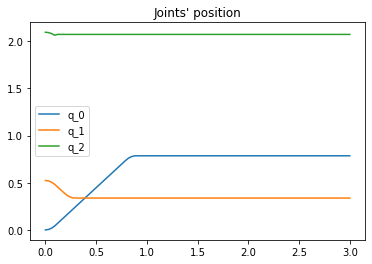

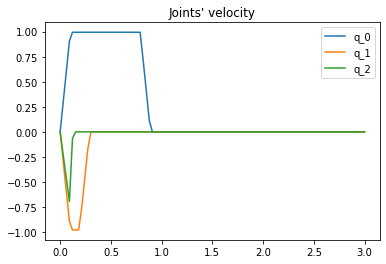

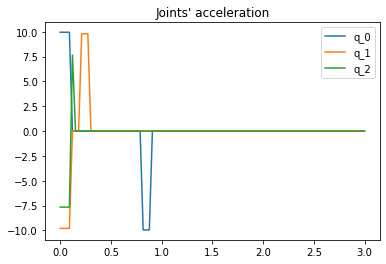

In [18]:
for i in range(len(Qs)):
    plt.plot(X, Qs[i], label="q_" + str(i))
    plt.legend()
    plt.title("Joints' position")
plt.show()

for i in range(len(dQs)):
    plt.plot(X, dQs[i], label="q_" + str(i))
    plt.legend()
    plt.title("Joints' velocity")
plt.show()

for i in range(len(ddQs)):
    plt.plot(X, ddQs[i], label="q_" + str(i))
    plt.legend()
    plt.title("Joints' acceleration")
plt.show()

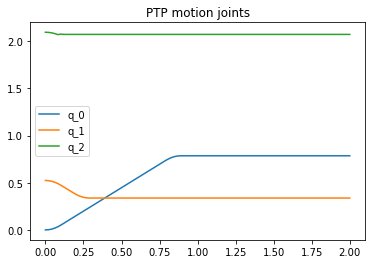

In [19]:
X = np.linspace(0,2,100)
q_real = []
for i, mp in enumerate(motion_params):
    Y = [q(t, motion_params[i]) for t in X]

    plt.plot(X,Y, label='q_' + str(i))
    plt.legend()
    plt.title("PTP motion joints")
    q_real.append(Y[-1]) # last state of joint
plt.show()

In [20]:
print("Joints error:", np.array(qf)-q_real)
print("Exptected joints:", qf)
print("Real joints:", q_real)

Joints error: [0. 0. 0.]
Exptected joints: [0.7853981633974483, 0.33767524734527354, 2.0714510391994847]
Real joints: [0.7853981633974483, 0.33767524734527354, 2.0714510391994847]


In [21]:
res = fk(q_real)

print("real EE position:", res)
print("Expected EE position:", p2)

real EE position: [0.70710678 0.70710678 1.2       ]
Expected EE position: [0.7071067811865476, 0.7071067811865476, 1.2]


In [23]:
# Before sync fixes here was 10-17 mm error :)
print("Error is:", np.linalg.norm(res - p2, ord=2) * 1000, 'mm')

Error is: 1.570092458683775e-13 mm
